In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import time
import torchvision
import copy
from torch.utils.data import Dataset, DataLoader, ConcatDataset
#from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from PIL import Image

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip 

^C


'unzip' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
def imgshow(title, image = None, size =6):
    w,h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size*aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

In [3]:
# Set directory paths for our files
train_dir = 'cats_vs_dogs/train'
test_dir = 'cats_vs_dogs/test1'

# Get files in our directories
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [4]:
print(f'Number of images in {train_dir} is {len(train_files)}')
print(f'Number of images in {test_dir} is {len(test_files)}')

Number of images in cats_vs_dogs/train is 25000
Number of images in cats_vs_dogs/test1 is 12500


In [5]:
print(cv2.__version__)

4.6.0


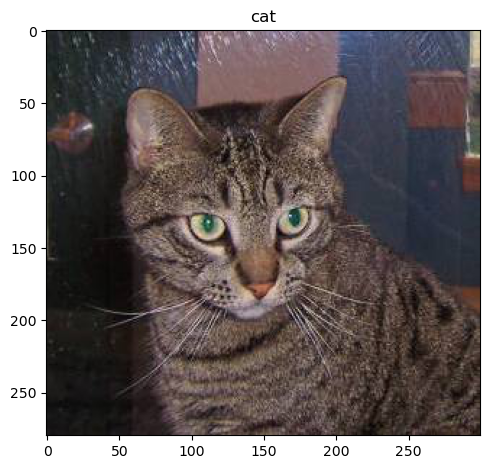

In [6]:
# Display a image
img = cv2.imread("cats_vs_dogs/train/"+train_files[1])
imgshow("cat",img)

In [10]:
img.shape

(280, 300, 3)

In [7]:
transformations = transforms.Compose([transforms.Resize((60,60)),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [8]:
# Create a Dataset class which stores our dataset information

class Dataset():
    def __init__(self, filelist, filepath, transform=None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))
    
    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

In [9]:
# Create our train and test dataset objects
train = Dataset(train_files, train_dir, transformations)
val = Dataset(test_files, test_dir, transformations)

In [11]:
print(train[0])

(tensor([[[ 0.6235,  0.6784,  0.7412,  ...,  0.9451,  0.9373,  0.9137],
         [ 0.6235,  0.6784,  0.7412,  ...,  0.9529,  0.9373,  0.9216],
         [ 0.6314,  0.6863,  0.7412,  ...,  0.9451,  0.9373,  0.9294],
         ...,
         [ 0.2863,  0.3098,  0.3412,  ..., -0.9765, -0.9686, -0.9765],
         [ 0.2549,  0.2784,  0.3176,  ..., -0.9765, -0.9765, -0.9765],
         [ 0.2157,  0.2549,  0.2941,  ..., -0.9843, -0.9843, -0.9843]],

        [[ 0.3176,  0.3647,  0.4118,  ...,  0.6941,  0.6471,  0.6000],
         [ 0.3176,  0.3647,  0.4118,  ...,  0.7098,  0.6706,  0.6235],
         [ 0.3098,  0.3569,  0.4039,  ...,  0.7098,  0.6941,  0.6627],
         ...,
         [ 0.0196,  0.0431,  0.0588,  ..., -0.9686, -0.9608, -0.9686],
         [-0.0118,  0.0118,  0.0353,  ..., -0.9686, -0.9686, -0.9765],
         [-0.0275, -0.0039,  0.0196,  ..., -0.9843, -0.9843, -0.9843]],

        [[-0.2863, -0.2392, -0.2000,  ...,  0.0980,  0.0196, -0.0353],
         [-0.2863, -0.2392, -0.2000,  ...,  

In [10]:
train.__getitem__(0)

(tensor([[[ 0.6235,  0.6784,  0.7412,  ...,  0.9451,  0.9373,  0.9137],
          [ 0.6235,  0.6784,  0.7412,  ...,  0.9529,  0.9373,  0.9216],
          [ 0.6314,  0.6863,  0.7412,  ...,  0.9451,  0.9373,  0.9294],
          ...,
          [ 0.2863,  0.3098,  0.3412,  ..., -0.9765, -0.9686, -0.9765],
          [ 0.2549,  0.2784,  0.3176,  ..., -0.9765, -0.9765, -0.9765],
          [ 0.2157,  0.2549,  0.2941,  ..., -0.9843, -0.9843, -0.9843]],
 
         [[ 0.3176,  0.3647,  0.4118,  ...,  0.6941,  0.6471,  0.6000],
          [ 0.3176,  0.3647,  0.4118,  ...,  0.7098,  0.6706,  0.6235],
          [ 0.3098,  0.3569,  0.4039,  ...,  0.7098,  0.6941,  0.6627],
          ...,
          [ 0.0196,  0.0431,  0.0588,  ..., -0.9686, -0.9608, -0.9686],
          [-0.0118,  0.0118,  0.0353,  ..., -0.9686, -0.9686, -0.9765],
          [-0.0275, -0.0039,  0.0196,  ..., -0.9843, -0.9843, -0.9843]],
 
         [[-0.2863, -0.2392, -0.2000,  ...,  0.0980,  0.0196, -0.0353],
          [-0.2863, -0.2392,

In [15]:
train.__getitem__(0)[0].shape

torch.Size([3, 60, 60])

In [16]:
#Using our dataset object to create our train, validation split
train_size = int(0.8*len(train_files))
print(train_size)
val_size = int(0.2*len(train_files))
print(val_size)
train, val = torch.utils.data.random_split(train, [train_size, val_size])

20000
5000


In [17]:
type(train)

torch.utils.data.dataset.Subset

In [18]:
# Dataloaders - let's create our iterable over a dataset

train_dataset = torch.utils.data.DataLoader(dataset=train, batch_size=32, shuffle=True)
val_dataset = torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

In [19]:
dataiter = iter(train_dataset)
samples, labels = next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


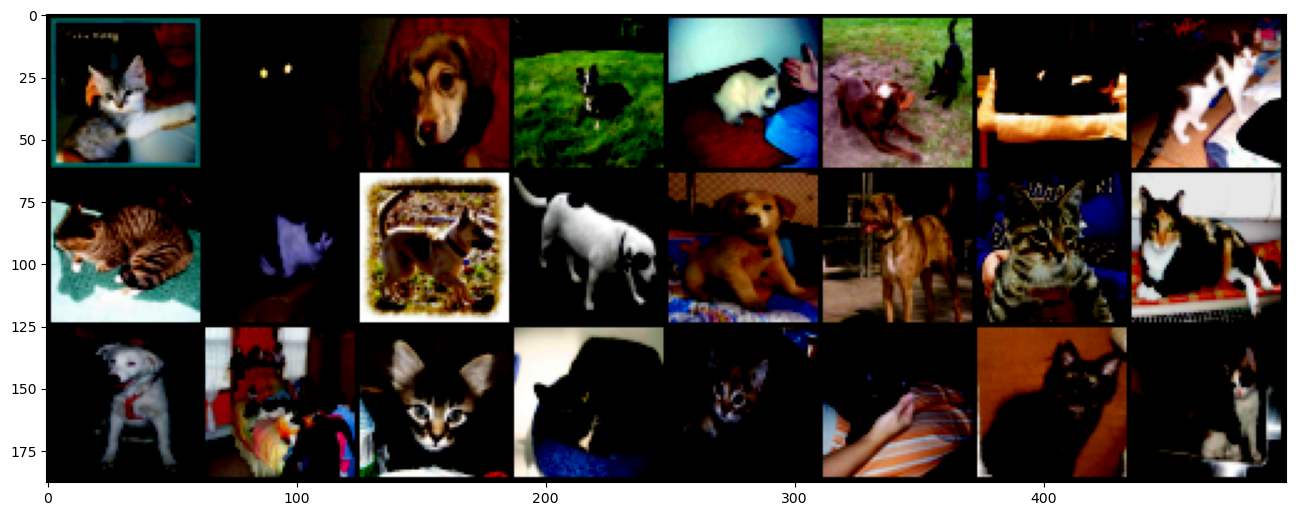

In [20]:
samples, labels = next(iter(train_dataset))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [21]:
# Build the model

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,16,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            ) 
            
        self.conv2 =   nn.Sequential(
            nn.Conv2d(16,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        ) 
        self.conv3 =   nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        ) 

        self.fc1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*5*5,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU()
        )
            
        self.fc2 = nn.Sequential(
        nn.Linear(128,2),
        )
                
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1) 

In [23]:
from torchsummary import summary

model = CNN()
model.to(device)
print(model)

ModuleNotFoundError: No module named 'torchsummary'

In [24]:
criterion = nn.CrossEntropyLoss().to(device)
optimiser = optim.Adam(model.parameters(),lr=0.0005)
epochs = 10

In [27]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(epochs):
    model.train()   # sets the module in training mode
    total = 0
    correct = 0
    counter = 0
    train_running_loss = 0

    with tqdm(train_dataset, unit="batch") as tepoch:
        tepoch.set_description(f'Epoch{epoch+1}/{epochs}') # get each batch in tepoch

        for data,label in tepoch:
            data,label = data.to(device), label.to(device)
            optimiser.zero_grad()
            output = model(data)
            loss = criterion(output, label)
            loss.backward()
            optimiser.step()
            train_running_loss += loss.item() * data.size(0)
            _, pred = torch.max(output.data, 1)

            total += label.size(0)
            correct += (pred==label).sum().item()

        train_accuracy.append(correct/total)
        train_loss.append(train_running_loss/len(train_dataset))
        print(f'Epoch {epoch+1} Training Accuracy = {correct/total}')
        print(f'Epoch {epoch+1} Training Loss = {train_running_loss/len(train_dataset)}')

    # Get validation accuracy and losses after training completes for current epoch with whole dataset
    if epoch %1 == 0:
        model.eval()
        total = 0
        correct = 0
        val_running_loss = 0

        # We don't need gradients for validation, so wrap in  no_grad to save memory
        with torch.no_grad():
            for val_data, val_label in val_dataset:
                val_data, val_label = val_data.to(device), val_label.to(device)
                val_output = model(val_data)
                loss_val = criterion(val_output, val_label)

                # Calacuate the running loss by multiplying loss value by batch size
                val_running_loss += loss_val.item() * val_data.size(0)
                _, pred = torch.max(val_output.data, 1)    
                total += val_label.size(0)
                correct += (pred == val_label).sum().item()

            val_accuracy.append(correct/total)
            # Calcuate loss per epoch by dividing runing loss by number of items in validation set
            val_loss.append(val_running_loss/len(val_dataset))

            #print(val_running_loss)
            print(f'Epoch {epoch+1} Validation Accuracy = {correct/total}')
            print(f'Epoch {epoch+1} Validation Loss = {val_running_loss/len(val_dataset)}')






    

C:\Users\indtal\AppData\Local\Temp\ipykernel_19852\2975588629.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(train_dataset, unit="batch") as tepoch:


  0%|          | 0/625 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [28]:
# We loop over the traing dataset multiple times (each time is called an epoch)
epochs = 10

# Create some empty arrays to store logs 
epoch_log = []
loss_log = []
accuracy_log = []

# Iterate for a specified number of epochs
for epoch in range(epochs):  
    print(f'Starting Epoch: {epoch+1}...')

    # We keep adding or accumulating our loss after each mini-batch in running_loss
    running_loss = 0.0

    # We iterate through our trainloader iterator
    # Each cycle is a minibatch
    for i, data in enumerate(train_dataset, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move our data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Clear the gradients before training by setting to zero
        # Required for a fresh start
        optimiser.zero_grad()

        # Forward -> backprop + optimize
        outputs = model(inputs) # Forward Propagation 
        loss = criterion(outputs, labels) # Get Loss (quantify the difference between the results and predictions)
        loss.backward() # Back propagate to obtain the new gradients for all nodes
        optimiser.step() # Update the gradients/weights

        # Print Training statistics - Epoch/Iterations/Loss/Accuracy
        running_loss += loss.item()
        if i % 50 == 49:    # show our loss every 50 mini-batches
            correct = 0 # Initialize our variable to hold the count for the correct predictions
            total = 0 # Initialize our variable to hold the count of the number of labels iterated

            # We don't need gradients for validation, so wrap in 
            # no_grad to save memory
            with torch.no_grad():
                # Iterate through the testloader iterator
                for data in val_dataset:
                    images, labels = data
                    # Move our data to GPU
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    # Foward propagate our test data batch through our model
                    outputs = model(images)

                     # Get predictions from the maximum value of the predicted output tensor
                     # we set dim = 1 as it specifies the number of dimensions to reduce
                    _, predicted = torch.max(outputs.data, dim = 1)
                    # Keep adding the label size or length to the total variable
                    total += labels.size(0)
                    # Keep a running total of the number of predictions predicted correctly
                    correct += (predicted == labels).sum().item()

                accuracy = 100 * correct / total
                epoch_num = epoch + 1
                actual_loss = running_loss / 50
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                running_loss = 0.0

    # Store training stats after each epoch
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    accuracy_log.append(accuracy)

print('Finished Training')

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 0.313, Test Accuracy = 100.000%
Epoch: 1, Mini-Batches Completed: 100, Loss: 0.313, Test Accuracy = 100.000%
Epoch: 1, Mini-Batches Completed: 150, Loss: 0.313, Test Accuracy = 100.000%


C:\Users\indtal\AppData\Local\anaconda3\envs\deepLearning\Lib\site-packages\gdown\cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
From (redirected): https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk&confirm=t&uuid=be376ca2-dae4-4098-877d-3754fbdf7d8d
To: c:\Users\indtal\OneDrive - Vanderlande\Desktop\Misc\other laptop data\All or Nothing\Deep Learning\Code & Models\dogs-vs-cats.zip

  0%|          | 0.00/852M [00:00<?, ?B/s]
  0%|          | 524k/852M [00:00<15:04, 941kB/s]
  0%|          | 1.05M/852M [00:01<13:34, 1.04MB/s]
  0%|          | 1.57M/852M [00:01<12:33, 1.13MB/s]
  0%|          | 2.10M/852M [00:01<11:49, 1.20MB/s]
  0%|          | 2.62M/852M [00:02<11:44, 1.20MB/s]
  0%|          | 3.15M/852M [00:02<11:17, 1.25MB/s]
  0%|          | 3.67M/852M

Epoch: 1, Mini-Batches Completed: 200, Loss: 0.313, Test Accuracy = 100.000%
Epoch: 1, Mini-Batches Completed: 250, Loss: 0.313, Test Accuracy = 100.000%
Epoch: 1, Mini-Batches Completed: 300, Loss: 0.313, Test Accuracy = 100.000%
Epoch: 1, Mini-Batches Completed: 350, Loss: 0.313, Test Accuracy = 100.000%
Epoch: 1, Mini-Batches Completed: 400, Loss: 0.313, Test Accuracy = 100.000%
Epoch: 1, Mini-Batches Completed: 450, Loss: 0.313, Test Accuracy = 100.000%
Epoch: 1, Mini-Batches Completed: 500, Loss: 0.313, Test Accuracy = 100.000%
Epoch: 1, Mini-Batches Completed: 550, Loss: 0.313, Test Accuracy = 100.000%
Epoch: 1, Mini-Batches Completed: 600, Loss: 0.313, Test Accuracy = 100.000%
Starting Epoch: 2...


KeyboardInterrupt: 

In [ ]:
epoch_log = [*range(epochs)]

# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, train_loss, 'r-')
ax2.plot(epoch_log, train_accuracy, 'b-')

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, val_loss, 'r-')
ax2.plot(epoch_log, val_accuarcy, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Test Accuracy', color='b')


In [ ]:
PATH = 'cats_vs_dogs/cats_vs_dogs_10_epochs.pt'
torch.save(model.state_dict(), PATH)